In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt

In [2]:
mnist_df = pd.read_csv('./data/mnist.csv')

X = mnist_df.drop('label', axis=1).to_numpy()
y = mnist_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, shuffle=True)

normalizer = preprocessing.MinMaxScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.fit_transform(X_test)

In [3]:
class MNIST_Neural_Network(nn.Module):
    def __init__(self, in_layer=784, hid_layer1=800, hid_layer2=130, hid_layer3=80, out_layer=10):
        super().__init__()
        self.w1 = nn.Linear(in_layer, hid_layer1)
        self.w2 = nn.Linear(hid_layer1, hid_layer2)
        self.w3 = nn.Linear(hid_layer2, hid_layer3)
        self.out = nn.Linear(hid_layer3, out_layer)
    
    def forward(self, x):
        x = F.relu(self.w1(x))
        x = F.relu(self.w2(x))
        x = F.relu(self.w3(x))
        x = self.out(x)
        
        return x

In [4]:
mnist_model = MNIST_Neural_Network()

In [5]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(mnist_model.parameters(), lr=0.01)

In [6]:
epochs = 130
losses = []

for i in range(epochs):
    # Forward propagation
    y_pred = mnist_model.forward(X_train)

    # Measure loss
    loss = criterion(y_pred, y_train)

    # Keep track of losses
    losses.append(loss.detach().numpy())

    # Print every 10 epochs
    if i % 10 == 0:
        print(f'Epoch {i}: loss = {loss}')

    
    # Back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch 0: loss = 2.3061745166778564
Epoch 10: loss = 1.1820954084396362
Epoch 20: loss = 0.5206363201141357
Epoch 30: loss = 0.331442266702652
Epoch 40: loss = 0.2540394961833954
Epoch 50: loss = 0.228451207280159
Epoch 60: loss = 0.1837613731622696
Epoch 70: loss = 0.15542100369930267
Epoch 80: loss = 0.14069372415542603
Epoch 90: loss = 0.18484683334827423
Epoch 100: loss = 0.11307581514120102
Epoch 110: loss = 0.10906992107629776
Epoch 120: loss = 0.09587745368480682


Text(0, 0.5, 'Loss')

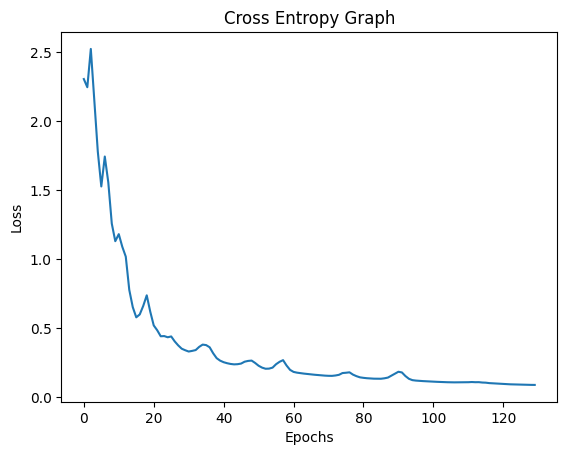

In [7]:
plt.plot(range(epochs), losses)
plt.title('Cross Entropy Graph')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [8]:
with torch.no_grad():
    y_eval = mnist_model.forward(X_test)
    loss = criterion(y_eval, y_test) # get loss/error of y_eval

print(float(loss))

17.70075798034668


In [9]:
def test_mnist(X_data, y_data):
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(X_data):
            y_val = mnist_model.forward(data)

            if (torch.argmax(y_val) == y_data[i]):
                correct +=  1

    return (correct/len(y_data)) * 100

In [10]:
print(f'Training Data Accuracy:\t {test_mnist(X_train, y_train):.2f}%')
print(f'Test Data Accuracy:\t {test_mnist(X_test, y_test):.2f}%')

Training Data Accuracy:	 97.49%
Test Data Accuracy:	 96.17%
